In [76]:
import torch
import tomosipo as ts
import numpy as np
from ts_algorithms import fbp, sirt, tv_min2d, fdk, nag_ls
import matplotlib.pyplot as plt
from PIL import Image

print(torch.__version__)

%load_ext autoreload
%autoreload 2

2.3.1
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [77]:
dev = torch.device("cuda")
print(torch.cuda.is_available())

True


In [78]:
def extract_square(image, corner, side_length):
    return image[corner[0]:corner[0]+side_length, corner[1]:corner[1]+side_length]

In [79]:
slice = np.array(Image.open(r"1471_P2_M2.bmp"), dtype=np.float32)
slice_shape = slice.shape
print(slice_shape)
corner = [slice.shape[0]//2-200, slice.shape[1]//2]
side_length = 400

(2484, 3916)


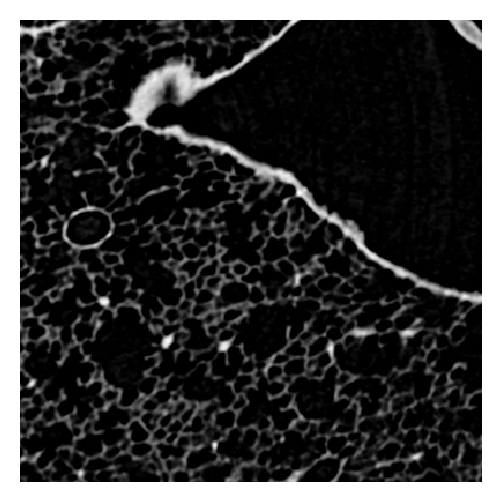

In [ ]:
sq = extract_square(slice, corner, side_length)
fig, ax = plt.subplots(figsize=(3,3), dpi=200)
ax.imshow(sq, cmap=plt.cm.Greys_r, interpolation='nearest')
ax.axis('off')
plt.show()

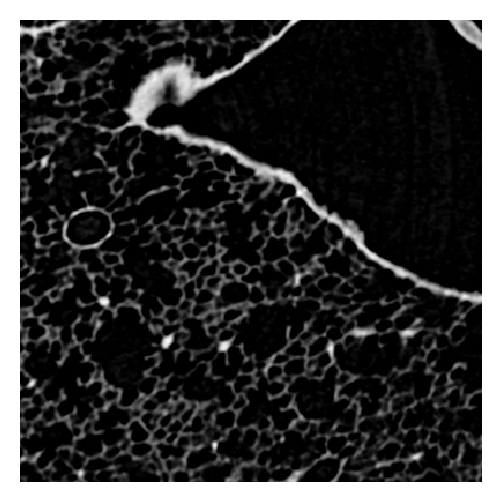

In [127]:
square_img = np.pad(sq, pad_width = sq.shape[0], mode='constant', constant_values=0)
fig, ax = plt.subplots(figsize=(3,3), dpi=200)
ax.imshow(square_img[400:800,400:800], cmap=plt.cm.Greys_r, interpolation='nearest')
ax.axis('off')
plt.show()

In [82]:
height, width = square_img.shape

In [83]:
# Setup up volume and parallel projection geometry
vg = ts.volume(shape=(1, width, width))
pg = ts.parallel(angles=900, shape=(1, width))
A = ts.operator(vg, pg)

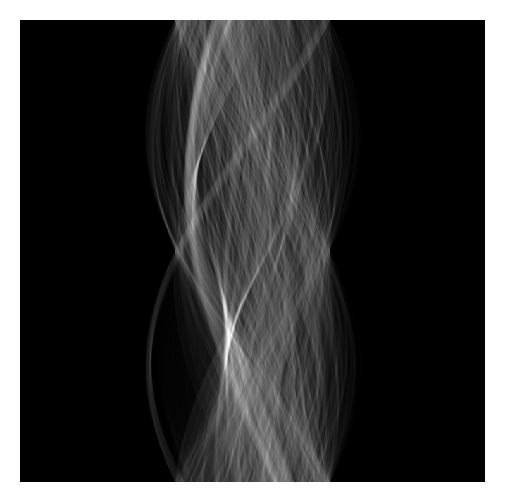

In [84]:
square_img = torch.from_numpy(square_img.reshape(1, *square_img.shape)).to(dev)
y = A(square_img)
fig, ax = plt.subplots(figsize=(3,3), dpi=200)
ax.imshow(y.detach().cpu().numpy().squeeze(), cmap=plt.cm.Greys_r, interpolation='nearest', aspect='auto')
ax.axis('off')
plt.show()

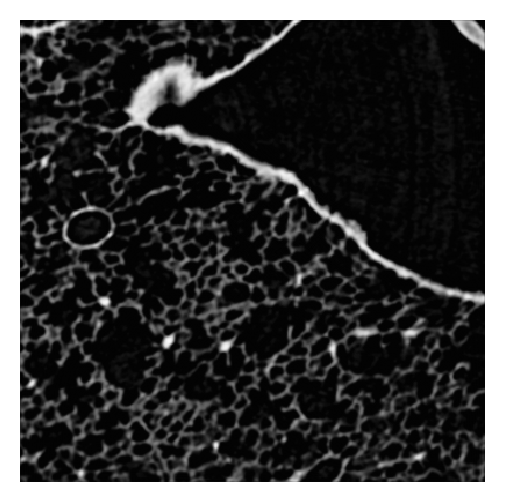

In [126]:
rec_fbp = fbp(A, y)
fig, ax = plt.subplots(figsize=(3,3), dpi=200)
ax.imshow(rec_fbp.detach().cpu().numpy().squeeze()[400:800,400:800], cmap=plt.cm.Greys_r, interpolation='nearest', aspect='auto')
ax.axis('off')
plt.show()

In [86]:
rec_nag_ls = nag_ls(A, y, num_iterations=500, progress_bar=True)
fig, ax = plt.subplots(figsize=(3,3), dpi=200)
ax.imshow(rec_nag_ls.detach().cpu().numpy().squeeze(), cmap=plt.cm.Greys_r, interpolation='nearest', aspect='auto')
ax.axis('off')
plt.show()

KeyboardInterrupt: 

In [104]:
def TV_test(A, y, lam, num_its, save_iterations=False):
    if save_iterations:
        rec_tv_min, all_iterations = tv_min2d(A, y, lam, num_iterations=num_its, progress_bar=True, save_iterations=save_iterations, plot=False)
        return rec_tv_min, all_iterations
    else:
        rec_tv_min = tv_min2d(A, y, lam, num_iterations=num_its, progress_bar=True, save_iterations=save_iterations, plot=False)
        return rec_tv_min
    # fig, ax = plt.subplots(figsize=(3,3), dpi=200)
    # ax.imshow(rec_tv_min.detach().cpu().numpy().squeeze(), cmap=plt.cm.Greys_r, interpolation='nearest', aspect='auto')
    # ax.axis('off')
    # plt.show()

In [102]:
rec_tv_min, all_iterations = tv_min2d(A, y, 0.0001, num_iterations=500, progress_bar=True, save_iterations=True, plot=False)
fig, ax = plt.subplots(figsize=(3,3), dpi=200)
ax.imshow(rec_tv_min.detach().cpu().numpy().squeeze(), cmap=plt.cm.Greys_r, interpolation='nearest', aspect='auto')
ax.axis('off')
plt.show()

100%|██████████| 500/500 [00:48<00:00, 10.25it/s]


AttributeError: 'list' object has no attribute 'shape'

In [121]:
lam_array = np.linspace(1e-2, 1e-1, 5)
num_its_array = [1000]

all_rec_tv = []

for lam in lam_array:
    lam_rec_tv = []
    for num_its in num_its_array:
        rec_tv_min = TV_test(A, y, lam, num_its, save_iterations=False)
        lam_rec_tv.append(rec_tv_min)
    all_rec_tv.append(lam_rec_tv)

100%|██████████| 1000/1000 [01:40<00:00,  9.92it/s]


In [113]:
num_its_array

[1000, 2000]

In [117]:
len(all_rec_tv[0])

2

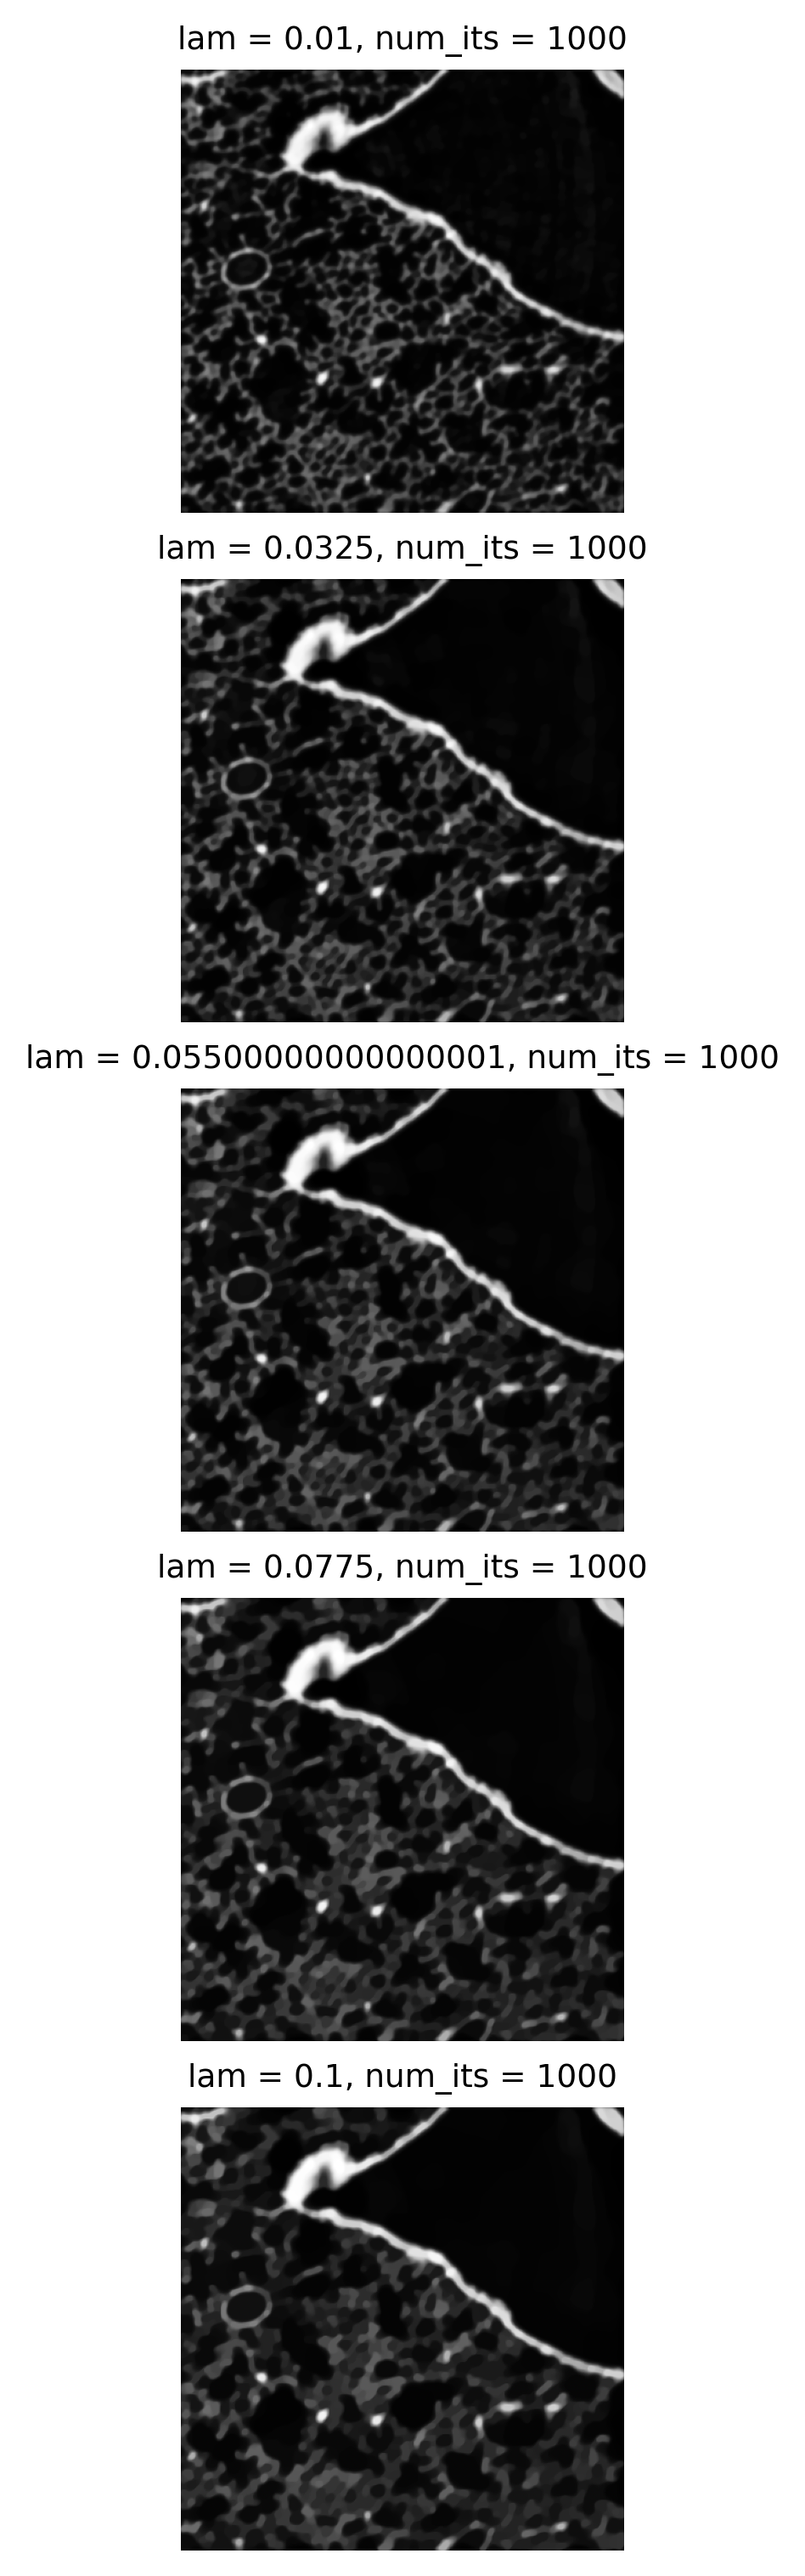

In [124]:
fig, ax = plt.subplots(len(lam_array), len(num_its_array), figsize=(8,10), dpi=300, layout='constrained')
for i, lam in enumerate(lam_array):
    for j, num_its in enumerate(num_its_array):
        ax[i].imshow(all_rec_tv[i][j].detach().cpu().numpy().squeeze()[400:800,400:800], cmap=plt.cm.Greys_r)
        ax[i].axis('off')
        ax[i].set_title(f"lam = {lam}, num_its = {num_its}", size=9)

plt.show()

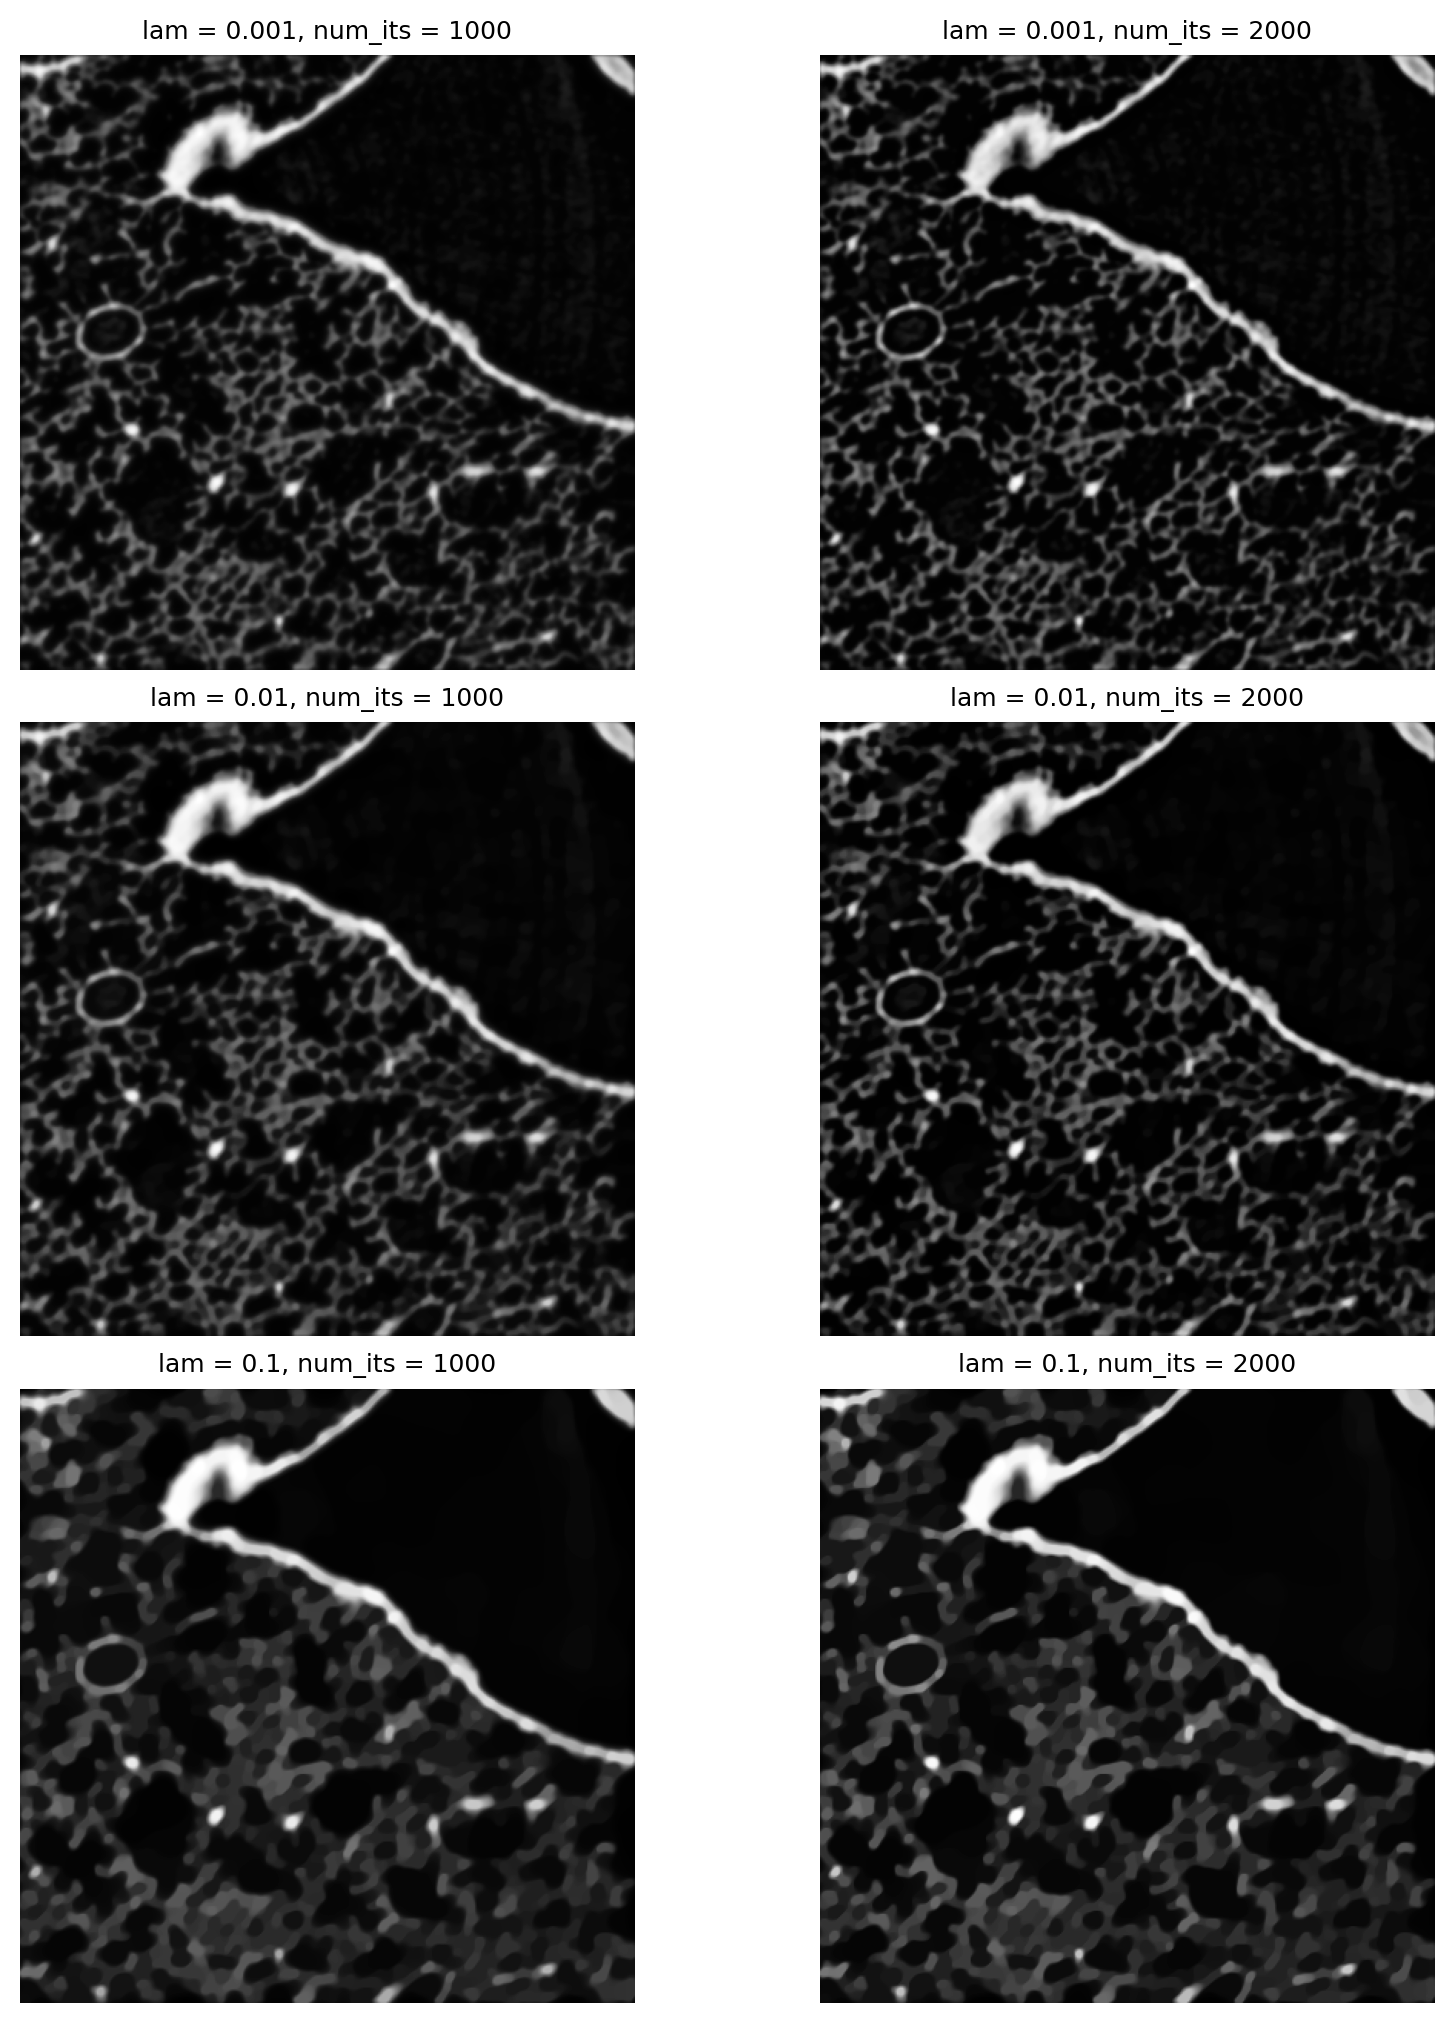

In [120]:
fig, ax = plt.subplots(len(lam_array), len(num_its_array), figsize=(8,10), dpi=200, layout='constrained')
for i, lam in enumerate(lam_array):
    for j, num_its in enumerate(num_its_array):
        ax[i][j].imshow(all_rec_tv[i][j].detach().cpu().numpy().squeeze()[400:800,400:800], cmap=plt.cm.Greys_r)
        ax[i][j].axis('off')
        ax[i][j].set_title(f"lam = {lam}, num_its = {num_its}", size=9)

plt.show()

In [ ]:


# reconstructions made with different algorithms
# rec_fbp = fbp(A, sino_slice)
# rec_sirt = sirt(A, sino_slice, num_iterations=100)
# rec_tv_min = tv_min2d(A, sino_slice, 0.0001, num_iterations=100)
# rec_nag_ls = nag_ls(A, sino_slice, num_iterations=100)

c:\Users\bherr\miniconda3\envs\tomosipo\lib\site-packages\tomosipo\links\torch.py:55: UserWarning: The parameter initial_value is of type torch.float64; expected `torch.float32`. The type has been automatically converted. Use `ts.link(x.to(dtype=torch.float32))' to inhibit this warning. 
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
# # Setup up volume and parallel projection geometry
# vg = ts.volume(shape=(1, 256, 256))
# pg = ts.parallel(angles=384, shape=(1, 384))
# A = ts.operator(vg, pg)

# # Create hollow cube phantom
# x = torch.zeros(A.domain_shape)
# x[:, 10:-10, 10:-10] = 1.0
# x[:, 20:-20, 20:-20] = 0.0

# # Forward project
# y = A(x)

# # reconstructions made with different algorithms
# rec_fbp = fbp(A, y)
# rec_sirt = sirt(A, y, num_iterations=100)
# rec_tv_min = tv_min2d(A, y, 0.0001, num_iterations=100)
# rec_nag_ls = nag_ls(A, y, num_iterations=100)

KeyboardInterrupt: 

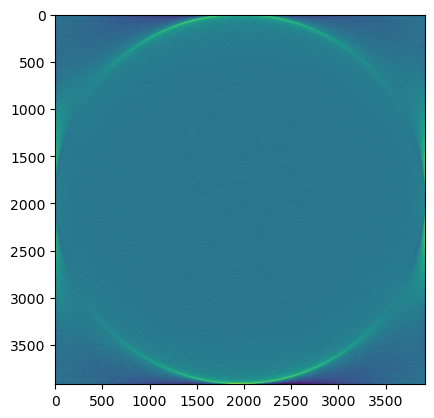

In [ ]:
# plt.imshow(rec_sirt.squeeze())